In [1]:
import glob
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.quantum_info import Statevector

import dqva

from utils.graph_funcs import *
from utils.helper_funcs import *

from ansatz import qaoa, qv_ansatz, dqv_ansatz, dqv_cut_ansatz

In [2]:
test_graphs = glob.glob('benchmark_graphs/N12_p20_graphs/*')
test_graphs = sorted(test_graphs, key=lambda g: int(g.split('/')[-1].strip('G.txt')))
print(len(test_graphs))

50


benchmark_graphs/N12_p20_graphs/G2.txt
Optimal: ('011111001010', 7)


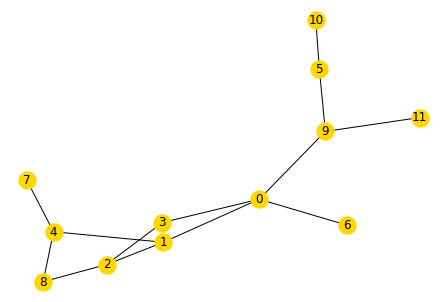

In [3]:
graph = test_graphs[1]
print(graph)
G = graph_from_file(graph)
print('Optimal:', brute_force_search(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [25]:
sample_graphs = test_graphs[0:50]
print(len(sample_graphs))
print(sample_graphs)

50
['benchmark_graphs/N12_p20_graphs/G1.txt', 'benchmark_graphs/N12_p20_graphs/G2.txt', 'benchmark_graphs/N12_p20_graphs/G3.txt', 'benchmark_graphs/N12_p20_graphs/G4.txt', 'benchmark_graphs/N12_p20_graphs/G5.txt', 'benchmark_graphs/N12_p20_graphs/G6.txt', 'benchmark_graphs/N12_p20_graphs/G7.txt', 'benchmark_graphs/N12_p20_graphs/G8.txt', 'benchmark_graphs/N12_p20_graphs/G9.txt', 'benchmark_graphs/N12_p20_graphs/G10.txt', 'benchmark_graphs/N12_p20_graphs/G11.txt', 'benchmark_graphs/N12_p20_graphs/G12.txt', 'benchmark_graphs/N12_p20_graphs/G13.txt', 'benchmark_graphs/N12_p20_graphs/G14.txt', 'benchmark_graphs/N12_p20_graphs/G15.txt', 'benchmark_graphs/N12_p20_graphs/G16.txt', 'benchmark_graphs/N12_p20_graphs/G17.txt', 'benchmark_graphs/N12_p20_graphs/G18.txt', 'benchmark_graphs/N12_p20_graphs/G19.txt', 'benchmark_graphs/N12_p20_graphs/G20.txt', 'benchmark_graphs/N12_p20_graphs/G21.txt', 'benchmark_graphs/N12_p20_graphs/G22.txt', 'benchmark_graphs/N12_p20_graphs/G23.txt', 'benchmark_graph

In [ ]:
qaoa_data = {}
dqva_data = {}

for graph_name in sample_graphs:
    print(graph_name)
    G = graph_from_file(graph_name)
    nq = len(G.nodes())
    opt_mis = brute_force_search(G)[1]
    
    init_state = '0'*nq
    mixer_order = list(range(nq))
    
    graph_key = graph_name.split('/')[-1].strip('.txt')
    graph_qaoa_data = []
    graph_dqva_data = []
    
    print('\n\nBEGIN QAOA\n\n')
    
    for P in [1,2,3]:
        output = dqva.solve_mis_qaoa(init_state, G, P=P, mixer_order=mixer_order, sim='qasm')
        ap_ratio = hamming_weight(output[0]) / opt_mis
        mixer_count = nq * P
        print('-'*30)
        print('Found approximation ratio = {}, with {} partial_mixers'.format(ap_ratio, mixer_count))
        print('-'*30)
        graph_qaoa_data.append((mixer_count, ap_ratio))
    
    qaoa_data[graph_key] = graph_qaoa_data
    
    print('\n\nBEGIN DQVA\n\n')

    for plim in [3, 9, 15, 21]:
        output = dqva.solve_mis_dqva(init_state, G, m=5, mixer_order=mixer_order, sim='qasm', param_lim=plim)
        ap_ratio = hamming_weight(output[0]) / opt_mis
        mixer_count = plim - 1
        print('-'*30)
        print('Found approximation ratio = {}, with {} partial_mixers'.format(ap_ratio, mixer_count))
        print('-'*30)
        graph_dqva_data.append((mixer_count, ap_ratio))
        
    dqva_data[graph_key] = graph_dqva_data

benchmark_graphs/N12_p20_graphs/G1.txt


BEGIN QAOA


Start round 1.1, Initial state = 000000000000
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -4.1343994140625
	Found new independent set: 000010010011, Hamming weight = 4
Start round 1.2, Initial state = 000010010011
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -4.0
	None of the measured bitstrings had higher Hamming weight than: 000010010011
	RETURNING, best hamming weight: 4
------------------------------
Found approximation ratio = 0.8, with 12 partial_mixers
------------------------------
Start round 1.1, Initial state = 000000000000
	Num params = 4
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -4.1951904296875
	Found new independent set: 000010010011, Hamming weight = 4
Start round 1.2, Initial state = 000010010011
	Num params = 4
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -4

In [8]:
print(qaoa_data)
print(dqva_data)

{'G2': [(12, 0.7142857142857143), (24, 1.0), (36, 1.0)], 'G3': [(12, 0.8333333333333334), (24, 0.8333333333333334), (36, 0.8333333333333334)]}
{'G2': [(2, 0.7142857142857143), (4, 0.7142857142857143), (6, 0.7142857142857143)], 'G3': [(2, 0.8333333333333334), (4, 0.8333333333333334), (6, 0.8333333333333334)]}


In [9]:
def plot_comparison(qaoa_data, dqva_data, savefig=False, show=True):
    assert(list(qaoa_data.keys()) == list(dqva_data.keys()))
    
    for graph in qaoa_data.keys():
        
        fig, ax = plt.subplots(dpi=150)
        
        for dat, label in zip([qaoa_data, dqva_data], ['QAOA', 'DQVA']):
            xvals = [tup[0] for tup in dat[graph]]
            yvals = [tup[1] for tup in dat[graph]]
            print(label)
            print(xvals)
            print(yvals)
        
            ax.plot(xvals, yvals, label=label)
        
        ax.set_title(graph)
        ax.legend()
        ax.set_ylabel('Approximation Ratio')
        ax.set_xlabel('Number of partial mixers')
        
        if show:
            plt.show()
        plt.close()

QAOA
[12, 24, 36]
[0.7142857142857143, 1.0, 1.0]
DQVA
[2, 4, 6]
[0.7142857142857143, 0.7142857142857143, 0.7142857142857143]


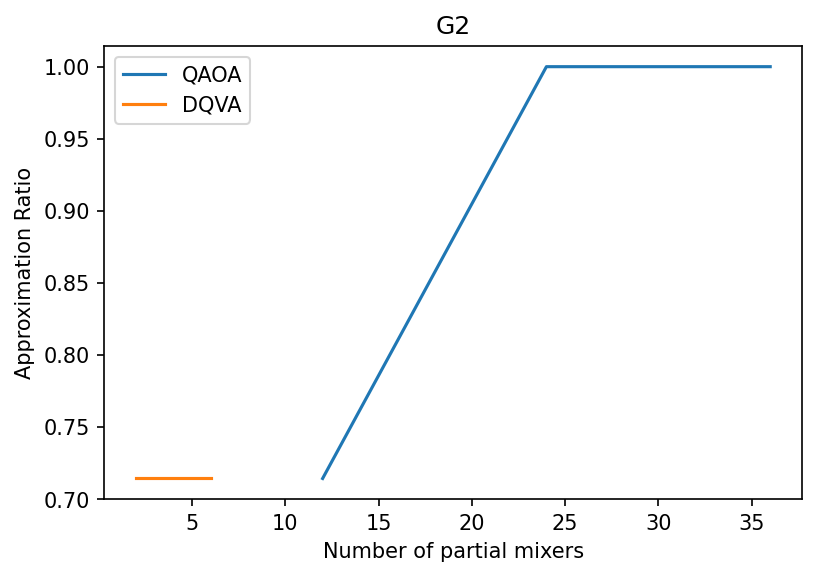

QAOA
[12, 24, 36]
[0.8333333333333334, 0.8333333333333334, 0.8333333333333334]
DQVA
[2, 4, 6]
[0.8333333333333334, 0.8333333333333334, 0.8333333333333334]


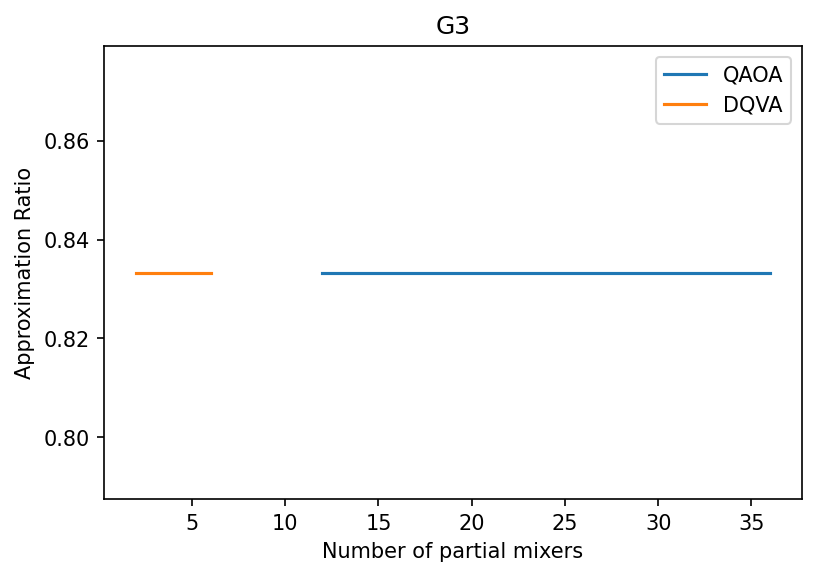

In [10]:
plot_comparison(qaoa_data, dqva_data)

In [ ]:
all_x = []
all_y = []
for key, data in qaoa_data.items():
    all_x.append([v[0] for v in data])
    all_y.append([v[1] for v in data])
all_x = np.mean(all_x, axis=0)
all_y = np.mean(all_y, axis=0)
avg_qaoa_data = {'Avg Erdos-Renyi N=12':list(zip(all_x, all_y))}

all_x = []
all_y = []
for key, data in dqva_data.items():
    all_x.append([v[0] for v in data])
    all_y.append([v[1] for v in data])
all_x = np.mean(all_x, axis=0)
all_y = np.mean(all_y, axis=0)
avg_dqva_data = {'Avg Erdos-Renyi N=12':list(zip(all_x, all_y))}

print(avg_qaoa_data)
print(avg_dqva_data)

In [ ]:
plot_comparison(avg_qaoa_data, avg_dqva_data)

## MISC testing

In [10]:
G = graph_from_file('benchmark_graphs/N12_p20_graphs/G2.txt')
nq = len(G.nodes())
init_state = '0'*nq
mo = list(range(nq))
param_lim = 2
P = 2
qaoa_output = dqva.solve_mis_qaoa(init_state, G, P=P, mixer_order=mo, sim='qasm', cutoff=1)
print('\nStart DQVA\n')
dqva_output = dqva.solve_mis_dqva(init_state, G, m=6, mixer_order=mo, sim='qasm', cutoff=1, param_lim=param_lim)

Start round 1.1, Initial state = 000000000000
	Num params = 4
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -5.5076904296875
	Found new independent set: 100111101010, Hamming weight = 7
Start round 1.2, Initial state = 100111101010
	Num params = 4
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -7.0
	None of the measured bitstrings had higher Hamming weight than: 100111101010
	RETURNING, best hamming weight: 7

Start DQVA

Start round 1.1, Initial state = 000000000000
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -1.0
	Found new independent set: 000000000001, Hamming weight = 1
Start round 1.2, Initial state = 000000000001
	Num params = 2
	Current Mixer Order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Optimal cost: -1.0
	None of the measured bitstrings had higher Hamming weight than: 000000000001
Start round 2.1, Initial state = 000000000001
	Num params = 2
	Current Mixer Order: [0, 5,

In [11]:
print(qaoa_output[0], qaoa_output[2], qaoa_output[3])
print(qaoa_output[1])
print()
print(dqva_output[0], dqva_output[2], dqva_output[3])
print(dqva_output[1])

100111101010 000000000000 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[ 2.52214283e+00 -2.02723472e-03 -9.60158258e-01  5.50223432e-02]

000000100101 000000100001 [0, 5, 2, 9, 10, 4, 11, 6, 3, 8, 7, 1]
[0.01232885 1.56283964]


In [12]:
qaoa_circ = qaoa.gen_qaoa(G, P, params=qaoa_output[1], init_state=qaoa_output[2],
                          mixer_order=qaoa_output[3], barriers=2)
qaoa_circ.measure_all()
#print(opt_circ.draw(fold=120))
qaoa_result = execute(qaoa_circ, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
qaoa_counts = qaoa_result.get_counts(qaoa_circ)

dqva_circ = dqv_ansatz.gen_dqva(G, P=1, params=dqva_output[1], init_state=dqva_output[2],
                                mixer_order=dqva_output[3], barriers=2, decompose_toffoli=1, param_lim=param_lim)
dqva_circ.measure_all()
dqva_result = execute(dqva_circ, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
dqva_counts = dqva_result.get_counts(dqva_circ)

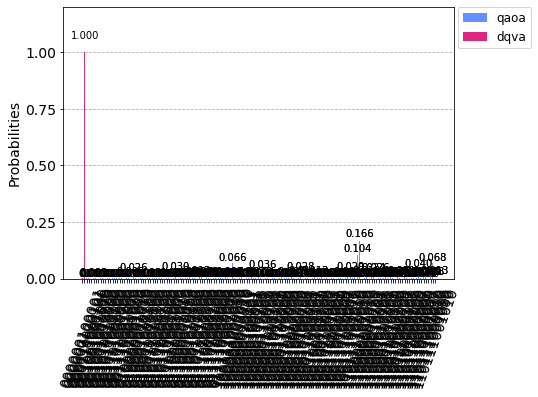

In [13]:
qiskit.visualization.plot_histogram([strip_ancillas(qaoa_counts, qaoa_circ), strip_ancillas(dqva_counts, dqva_circ)], legend=['qaoa', 'dqva'])